# Step 2: Exploratory Data Analysis (EDA) and Initial Preprocessing

## Purpose
The purpose of this notebook is to perform Exploratory Data Analysis (EDA) on the filtered Open Food Facts dataset (`food.csv`) produced in Step 1. We want to understand the data structure, distributions, and relationships between features, and to identify any data quality issues before preprocessing.

---

## Tasks

### Data Exploration
- Determine the number of observations in the dataset.
- Describe all columns, including:
  - Variable type (categorical, continuous, text, etc.)
  - Scale (nominal, ordinal, ratio)
  - Data distributions (summary statistics, value counts)
- Identify the target column (`nutriscore_grade`) and describe its classes.
- Detect missing values and duplicate rows.
- For text fields or semi-structured JSON columns, provide a summary of content (e.g., most common ingredients or labels).

### Data Plots
- Visualize the data using bar charts, pie charts, histograms, scatter plots, or other appropriate plots.
- Highlight insights from the plots, such as:
  - Distribution of Nutri-Score grades
  - Frequency of top categories, brands, or ingredients
  - Relationships between numeric features (e.g., sugar, fat, energy)
  

> Note: For image datasets, include examples of classes, image counts, sizes, and preprocessing requirements (cropping, resizing, normalization).  

### Preprocessing Plan
- Explain how you plan to preprocess the data in the next step, including:
  - Handling missing values
  - Normalizing or scaling continuous features
  - Encoding categorical variables
  - Handling class imbalance in the target variable
- Do not perform preprocessing here; this will be implemented in Step 3.  

---

## Output
- Insights and summary statistics from EDA.
- Visualizations showing distributions and relationships in the data.
- Documentation of data quality issues and preprocessing plan.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
# Load the dataset
df = pd.read_csv("../data/food.csv", low_memory=False)
df.head()

,code,brands,product,lang,categories_tags,food_groups_tags,labels_tags,additives_n,additives_tags,allergens_tags,...,completeness,energy,sugars,added_sugars,carbohydrates,salt,fat,trans_fat,proteins,nutriscore_grade
0,0000105000417,Lagg's,"Lagg's, dieter's herbal tea",en,"['plant-based-foods-and-beverages', 'beverages...","['beverages', 'unsweetened-beverages']",NaN,0.0,[],[],...,0.5000,0.0,NaN,NaN,0.000000,0.00,0.000000,NaN,0.00,b
1,0000111048403,Canola Harvest,100% Pure Canola Oil,en,"['plant-based-foods-and-beverages', 'plant-bas...","['fats-and-sauces', 'fats']",NaN,0.0,[],[],...,0.5000,3586.0,NaN,NaN,0.000000,0.00,100.000000,0.0,0.00,b
2,0000111301201,Canola Harvest,Canola Harvest® Original Vegetable Oil Spread Tub,en,['dairies'],[],[],4.0,"['e202', 'e322', 'e322i', 'e330', 'e471']","['milk', 'soybeans']",...,0.6625,19200.0,0.0,NaN,0.000000,12.70,510.000000,0.0,0.00,e
3,0000111301263,Canola Harvest,"Canola harvest, buttery spread, with flaxseed oil",en,['fats'],"['fats-and-sauces', 'fats']",NaN,5.0,"['e202', 'e322', 'e322i', 'e330', 'e385', 'e471']","['milk', 'soybeans']",...,0.5000,2389.0,0.0,NaN,0.000000,1.34,57.139999,0.0,0.00,d
4,0000127534587,Today's Temptations,Lithuanian Rye Bread,en,['null'],[],NaN,0.0,[],['gluten'],...,0.6000,1390.0,15.4,NaN,83.099998,2.46,4.610000,0.0,9.23,e


In [21]:
# rows, columns
df.shape

(424297, 24)

In [22]:
# column datatypes
df.dtypes

code                            object
brands                          object
product                         object
lang                            object
categories_tags                 object
food_groups_tags                object
labels_tags                     object
additives_n                    float64
additives_tags                  object
allergens_tags                  object
ingredients_analysis_tags       object
ingredients_n                  float64
ingredients_from_palm_oil_n    float64
ingredients                     object
completeness                   float64
energy                         float64
sugars                         float64
added_sugars                   float64
carbohydrates                  float64
salt                           float64
fat                            float64
trans_fat                      float64
proteins                       float64
nutriscore_grade                object
dtype: object

In [20]:
# missing values per column
df.isnull().sum()

code                                0
brands                         116939
product                            12
lang                                0
categories_tags                     0
food_groups_tags                    0
labels_tags                    305699
additives_n                         1
additives_tags                      0
allergens_tags                      0
ingredients_analysis_tags          99
ingredients_n                       1
ingredients_from_palm_oil_n     85832
ingredients                         0
completeness                        0
energy                           3980
sugars                          13036
added_sugars                   399463
carbohydrates                    4804
salt                             4116
fat                              4002
trans_fat                      173995
proteins                         4015
nutriscore_grade                    0
dtype: int64

{'a': 62500, 'b': 47033, 'c': 81611, 'd': 98591, 'e': 134562}


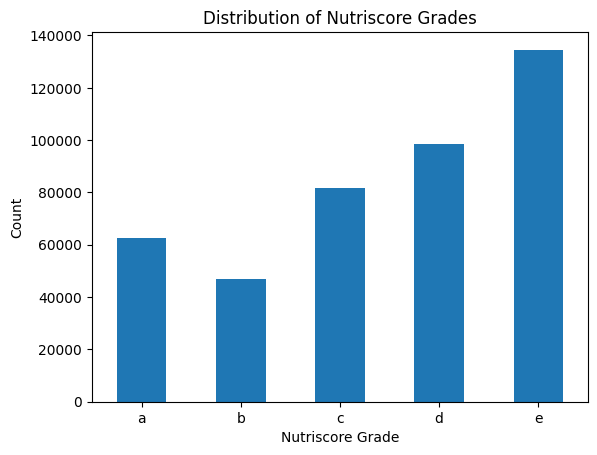

In [32]:
# plot distribution of nutriscore grades
counts = df["nutriscore_grade"].value_counts().reindex(["a", "b", "c", "d", "e"])
print(counts.to_dict())
counts.plot(kind="bar")
plt.xlabel("Nutriscore Grade")
plt.ylabel("Count")
plt.title("Distribution of Nutriscore Grades")
plt.xticks(rotation=0)
plt.show()